# PROJECT : SCORING CLIENT

> Ref. Simplonline : https://simplonline.co/briefs/a1e3b434-ff7f-477c-9354-e052fd1a85f7

***Project context*** <br>
Votre client souhaite mettre à disposition un tableau de bord à ses conseillers financiers indiquant diverses informations et indicateurs. <br>
Le but de ce projet est de montrer une première itération complète (ML + déploiement) [...]

In [ ]:
!python3.9 -m pip install --no-cache-dir -r 'requirements.txt' 

In [ ]:
from IPython.display import display

import datetime
import os
import sys
print(sys.executable, sys.version)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from lazypredict.Supervised import LazyClassifier

------
### DATA IMPORTS

In [3]:
%%time

# Load provided CSV files and stores them in variables such as :
# > df_[<name_of_csv_file_withtout_extension>] = csv data as pd.DataFrame

DISPlAY = True

EXCLUDE = ['HomeCredit_columns_description.csv']
ENCODING = 'ISO-8859-1'
DIR_PATH = './data'
DATA_PATH = os.listdir(DIR_PATH)
N_DATA_CSV = len([f for f in DATA_PATH if f not in EXCLUDE])

list_labels = []
print('Data importation :\n')
for file in DATA_PATH:
    print('-' * 150, '\nFrom :', file)
    if file not in EXCLUDE:
        df = pd.read_csv(os.path.join(DIR_PATH, file), encoding = ENCODING, memory_map = True)
        file_str = file.split('.')[0]
        var_name = 'df_{}'.format(file_str)
        globals()[var_name] = df
        describe = df.describe()
        list_labels.append(df.columns.to_list())
        print('File loaded -> {}'.format(var_name), '\n')
        if DISPlAY:
            display(df.head(1), describe)
    else:
        print('This file is ignored')
    
if DISPlAY:
    print('\nList of all labels :\n', ', '.join([j for sub in list_labels for j in sub]))
else:
    print('\n\nImport data : OK')

Data importation :

------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : application_test.csv
File loaded -> df_application_test 



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.00,568800.00,20560.50,450000.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.00,48744.00,48744.00,48744.00,48720.00,48744.00,48744.00,48744.00,48744.00,48744.00,...,48744.00,48744.00,48744.00,48744.00,42695.00,42695.00,42695.00,42695.00,42695.00,42695.00
mean,277796.68,0.40,178431.81,516740.44,29426.24,462618.84,0.02,-16068.08,67485.37,-4967.65,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.55,1.98
std,103169.55,0.71,101522.59,365397.00,16016.37,336710.22,0.01,4325.90,144348.51,3552.61,...,0.04,0.00,0.00,0.00,0.05,0.05,0.05,0.11,0.69,1.84
min,100001.00,0.00,26941.50,45000.00,2295.00,45000.00,0.00,-25195.00,-17463.00,-23722.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,188557.75,0.00,112500.00,260640.00,17973.00,225000.00,0.01,-19637.00,-2910.00,-7459.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,277549.00,0.00,157500.00,450000.00,26199.00,396000.00,0.02,-15785.00,-1293.00,-4490.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
75%,367555.50,1.00,225000.00,675000.00,37390.50,630000.00,0.03,-12496.00,-296.00,-1901.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00
max,456250.00,20.00,4410000.00,2245500.00,180576.00,2245500.00,0.07,-7338.00,365243.00,0.00,...,1.00,0.00,0.00,0.00,2.00,2.00,2.00,6.00,7.00,17.00


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : HomeCredit_columns_description.csv
This file is ignored
------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : POS_CASH_balance.csv
File loaded -> df_POS_CASH_balance 



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,10001358.00,10001358.00,10001358.00,9975287.00,9975271.00,10001358.00,10001358.00
mean,1903216.60,278403.86,-35.01,17.09,10.48,11.61,0.65
std,535846.53,102763.75,26.07,12.00,11.11,132.71,32.76
min,1000001.00,100001.00,-96.00,1.00,0.00,0.00,0.00
25%,1434405.00,189550.00,-54.00,10.00,3.00,0.00,0.00
50%,1896565.00,278654.00,-28.00,12.00,7.00,0.00,0.00
75%,2368963.00,367429.00,-13.00,24.00,14.00,0.00,0.00
max,2843499.00,456255.00,-1.00,92.00,85.00,4231.00,3595.00


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : credit_card_balance.csv
File loaded -> df_credit_card_balance 



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,1700.33,...,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3840312.00,3840312.00,3840312.00,3840312.00,3840312.00,3090496.00,3840312.00,3090496.00,3090496.00,3535076.00,...,3840312.00,3840312.00,3840312.00,3090496.00,3840312.00,3090496.00,3090496.00,3535076.00,3840312.00,3840312.00
mean,1904503.59,278324.21,-34.52,58300.16,153807.96,5961.32,7433.39,288.17,2968.80,3540.20,...,55965.88,58088.81,58098.29,0.31,0.70,0.00,0.56,20.83,9.28,0.33
std,536469.47,102704.48,26.67,106307.03,165145.70,28225.69,33846.08,8201.99,20796.89,5600.15,...,102533.62,105965.37,105971.80,1.10,3.19,0.08,3.24,20.05,97.52,21.48
min,1000018.00,100006.00,-96.00,-420250.18,0.00,-6827.31,-6211.62,0.00,0.00,0.00,...,-423305.82,-420250.18,-420250.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1434385.00,189517.00,-55.00,0.00,45000.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00
50%,1897122.00,278396.00,-28.00,0.00,112500.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00
75%,2369327.75,367580.00,-11.00,89046.69,180000.00,0.00,0.00,0.00,0.00,6633.91,...,85359.24,88899.49,88914.51,0.00,0.00,0.00,0.00,32.00,0.00,0.00
max,2843496.00,456250.00,-1.00,1505902.19,1350000.00,2115000.00,2287098.31,1529847.00,2239274.16,202882.01,...,1472316.79,1493338.19,1493338.19,51.00,165.00,12.00,165.00,120.00,3260.00,3260.00


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : installments_payments.csv
File loaded -> df_installments_payments 



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,-1180.00,-1187.00,6948.36,6948.36


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,13605401.00,13605401.00,13605401.00,13605401.00,13605401.00,13602496.00,13605401.00,13602496.00
mean,1903364.97,278444.88,0.86,18.87,-1042.27,-1051.11,17050.91,17238.22
std,536202.91,102718.31,1.04,26.66,800.95,800.59,50570.25,54735.78
min,1000001.00,100001.00,0.00,1.00,-2922.00,-4921.00,0.00,0.00
25%,1434191.00,189639.00,0.00,4.00,-1654.00,-1662.00,4226.09,3398.26
50%,1896520.00,278685.00,1.00,8.00,-818.00,-827.00,8884.08,8125.52
75%,2369094.00,367530.00,1.00,19.00,-361.00,-370.00,16710.21,16108.42
max,2843499.00,456255.00,178.00,277.00,-1.00,-1.00,3771487.85,3771487.85


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : application_train.csv
File loaded -> df_application_train 



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00,307511.00,307511.00,307511.00,307511.00,307499.00,307233.00,307511.00,307511.00,307511.00,...,307511.00,307511.00,307511.00,307511.00,265992.00,265992.00,265992.00,265992.00,265992.00,265992.00
mean,278180.52,0.08,0.42,168797.92,599026.00,27108.57,538396.21,0.02,-16037.00,63815.05,...,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.27,0.27,1.90
std,102790.18,0.27,0.72,237123.15,402490.78,14493.74,369446.46,0.01,4363.99,141275.77,...,0.09,0.02,0.02,0.02,0.08,0.11,0.20,0.92,0.79,1.87
min,100002.00,0.00,0.00,25650.00,45000.00,1615.50,40500.00,0.00,-25229.00,-17912.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,189145.50,0.00,0.00,112500.00,270000.00,16524.00,238500.00,0.01,-19682.00,-2760.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,278202.00,0.00,0.00,147150.00,513531.00,24903.00,450000.00,0.02,-15750.00,-1213.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,367142.50,0.00,1.00,202500.00,808650.00,34596.00,679500.00,0.03,-12413.00,-289.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
max,456255.00,1.00,19.00,117000000.00,4050000.00,258025.50,4050000.00,0.07,-7489.00,365243.00,...,1.00,1.00,1.00,1.00,4.00,9.00,8.00,27.00,261.00,25.00


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : bureau.csv
File loaded -> df_bureau 



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,nan,0,91323.00,0.00,nan,0.00,Consumer credit,-131,nan


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1716428.00,1716428.00,1716428.00,1716428.00,1610875.00,1082775.00,591940.00,1716428.00,1716415.00,1458759.00,1124648.00,1716428.00,1716428.00,489637.00
mean,278214.93,5924434.49,-1142.11,0.82,510.52,-1017.44,3825.42,0.01,354994.59,137085.12,6229.51,37.91,-593.75,15712.76
std,102938.56,532265.73,795.16,36.54,4994.22,714.01,206031.61,0.10,1149811.34,677401.13,45032.03,5937.65,720.75,325826.95
min,100001.00,5000000.00,-2922.00,0.00,-42060.00,-42023.00,0.00,0.00,0.00,-4705600.32,-586406.11,0.00,-41947.00,0.00
25%,188866.75,5463953.75,-1666.00,0.00,-1138.00,-1489.00,0.00,0.00,51300.00,0.00,0.00,0.00,-908.00,0.00
50%,278055.00,5926303.50,-987.00,0.00,-330.00,-897.00,0.00,0.00,125518.50,0.00,0.00,0.00,-395.00,0.00
75%,367426.00,6385681.25,-474.00,0.00,474.00,-425.00,0.00,0.00,315000.00,40153.50,0.00,0.00,-33.00,13500.00
max,456255.00,6843457.00,0.00,2792.00,31199.00,0.00,115987185.00,9.00,585000000.00,170100000.00,4705600.32,3756681.00,372.00,118453423.50


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : previous_application.csv
File loaded -> df_previous_application 



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.00,17145.00,0.00,17145.00,SATURDAY,15,...,Connectivity,12.00,middle,POS mobile with interest,365243.00,-42.00,300.00,-42.00,-37.00,0.00


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.00,1670214.00,1297979.00,1670214.00,1670213.00,774370.00,1284699.00,1670214.00,1670214.00,774370.00,...,5951.00,1670214.00,1670214.00,1297984.00,997149.00,997149.00,997149.00,997149.00,997149.00,997149.00
mean,1923089.14,278357.17,15955.12,175233.86,196114.02,6697.40,227847.28,12.48,1.00,0.08,...,0.77,-880.68,313.95,16.05,342209.86,13826.27,33767.77,76582.40,81992.34,0.33
std,532597.96,102814.82,14782.14,292779.76,318574.62,20921.50,315396.56,3.33,0.06,0.11,...,0.10,779.10,7127.44,14.57,88916.12,72444.87,106857.03,149647.42,153303.52,0.47
min,1000001.00,100001.00,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,...,0.37,-2922.00,-1.00,0.00,-2922.00,-2892.00,-2801.00,-2889.00,-2874.00,0.00
25%,1461857.25,189329.00,6321.78,18720.00,24160.50,0.00,50841.00,10.00,1.00,0.00,...,0.72,-1300.00,-1.00,6.00,365243.00,-1628.00,-1242.00,-1314.00,-1270.00,0.00
50%,1923110.50,278714.50,11250.00,71046.00,80541.00,1638.00,112320.00,12.00,1.00,0.05,...,0.84,-581.00,3.00,12.00,365243.00,-831.00,-361.00,-537.00,-499.00,0.00
75%,2384279.75,367514.00,20658.42,180360.00,216418.50,7740.00,234000.00,15.00,1.00,0.11,...,0.85,-280.00,82.00,24.00,365243.00,-411.00,129.00,-74.00,-44.00,1.00
max,2845382.00,456255.00,418058.15,6905160.00,6905160.00,3060045.00,6905160.00,23.00,1.00,1.00,...,1.00,-1.00,4000000.00,84.00,365243.00,365243.00,365243.00,365243.00,365243.00,1.00


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : bureau_balance.csv
File loaded -> df_bureau_balance 



,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C


,SK_ID_BUREAU,MONTHS_BALANCE
count,27299925.00,27299925.00
mean,6036297.33,-30.74
std,492348.86,23.86
min,5001709.00,-96.00
25%,5730933.00,-46.00
50%,6070821.00,-25.00
75%,6431951.00,-11.00
max,6842888.00,0.00


------------------------------------------------------------------------------------------------------------------------------------------------------ 
From : sample_submission.csv
File loaded -> df_sample_submission 



,SK_ID_CURR,TARGET
0,100001,0.50


,SK_ID_CURR,TARGET
count,48744.00,48744.00
mean,277796.68,0.50
std,103169.55,0.00
min,100001.00,0.50
25%,188557.75,0.50
50%,277549.00,0.50
75%,367555.50,0.50
max,456250.00,0.50



List of all labels :
 SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMEN

In [4]:
# Make sure all CSV files were loaded
dfs = {key: globals()[key] for key in globals() if str(key).startswith('df_') and key not in EXCLUDE}
print('Loaded dataframes ({}/{}) :'.format(len(dfs.keys()), N_DATA_CSV), ', '.join(list(dfs.keys())))

dfs_raw = [globals()[df] for df in list(dfs.keys())]
data_points = []
for df in dfs_raw:
    data_points.append(len(df.columns) * len(df.index))
print('The entiere dataset contains :', sum(data_points), 'data points')

Loaded dataframes (9/9) : df_application_test, df_POS_CASH_balance, df_credit_card_balance, df_installments_payments, df_application_train, df_bureau, df_previous_application, df_bureau_balance, df_sample_submission
The entiere dataset contains : 493570071 data points


> There is a total of 10 CSV files. 9 of those are proper data, one is a description file (data dictionnary like). <br>
> This represents around 2.6GB of disk storage.

------
### MICRO EDA & TRANFORM DATA

In [5]:
# Merge dfs to get targets values
df_application_test = pd.merge(df_application_test, df_sample_submission, on='SK_ID_CURR')

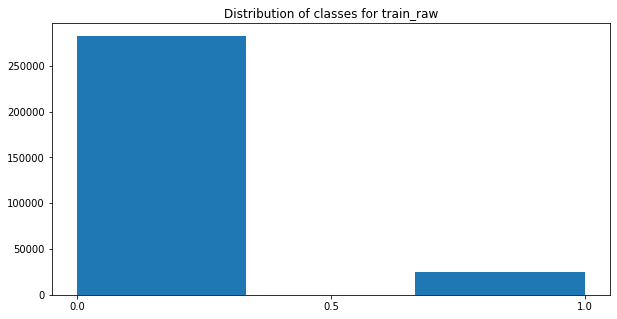

Ratio train_raw : 1:0.08781828601345662


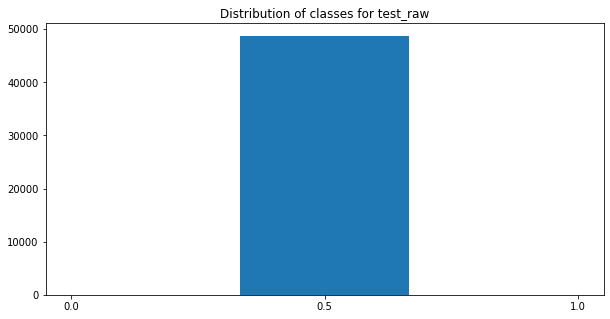

There is only one class.


In [6]:
# Check repartition of targets
def getRatio(dfs, title=[]):    
    for i, df in enumerate(dfs):
        plt.figure(figsize=(10, 5))
        plt.hist(df[['TARGET']], bins=3)
        plt.xticks([0, 0.5, 1])
        plt.title('Distribution of classes for {}'.format(title[i]))
        plt.show()
        
        if len(df['TARGET'].value_counts()) > 1:
            zeros, ones = df['TARGET'].value_counts()
            ratio = '1:{}'.format(ones / zeros)
            print('Ratio {} : {}'.format(title[i], ratio))
        else:
            print('There is only one class.')
    
getRatio([df_application_train, df_application_test], ['train_raw', 'test_raw'])

> The train dataset is particularly imbalanced. The ratio is about 1:0.087 <br>
> The test dataset contains only one class (??)

In [7]:
# Get infos about missing values
nas = pd.DataFrame(df_application_train.isna().sum()).rename(columns={
    0: 'Count'
})
display(nas[nas['Count'] > 0].T)
print('Total missing values :', sum(nas['Count']))

,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Count,12,278,1292,202929,96391,2,173378,660,60965,156061,...,1021,1021,1021,1,41519,41519,41519,41519,41519,41519


Total missing values : 9152465


> There are a lot of missing values, approximately 9m ! <br>
> Because of the lack of time, I'll simply drop them : <br>
> TO DO : <br>
> - Choose a better technique

In [8]:
# Remove NAs
prev_len_train = len(df_application_train.index)
prev_len_test = len(df_application_test.index)

df_application_train.dropna(inplace=True)
df_application_test.dropna(inplace=True)

new_len_train = len(df_application_train.index)
new_len_test = len(df_application_test.index)

perc_train = (new_len_train / prev_len_train) * 100
perc_test = (new_len_test / prev_len_test) * 100
print('On train, {} ({}%) rows have been dropped'.format(new_len_train, perc_train))
print('On test, {} ({}%) rows have been dropped'.format(new_len_test, perc_test))

On train, 8602 (2.7972983080280054%) rows have been dropped
On test, 1739 (3.567618578696865%) rows have been dropped


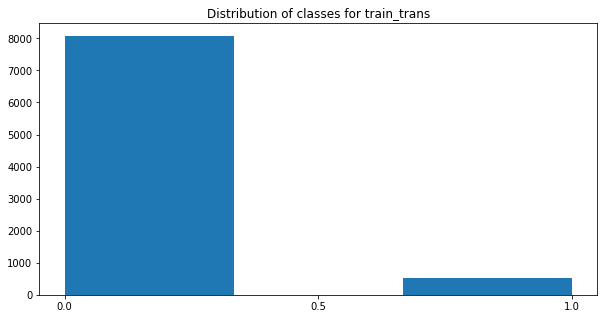

Ratio train_trans : 1:0.06513125309559188


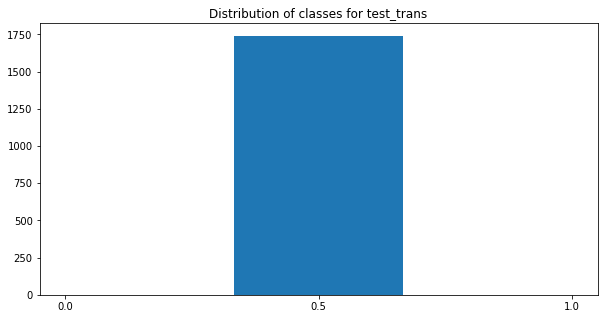

There is only one class.


In [9]:
# Check labels distribution after dropna
getRatio([df_application_train, df_application_test], ['train_trans', 'test_trans'])

> Ratio for train has decrease

In [10]:
# Check duplicated values
print('Count of duplicated value(s) in train : {}'.format(df_application_train.duplicated().sum()))
print('Count of duplicated value(s) in test : {}'.format(df_application_test.duplicated().sum()))

Count of duplicated value(s) in train : 0
Count of duplicated value(s) in test : 0


> TO DO EDA GENERAL : <br>
> - Feature corr
> - Feature selection
> - Dimensionality reduction (?)

------
### ML DATA PREP

In [143]:
target_label = 'TARGET'
identifier = 'SK_ID_CURR'
exclude_label = [ 'test_2011-06-11', 'test']

X_train = df_application_train[[x for x in df_application_train.columns if x not in exclude_label]]
X_train = pd.get_dummies(X_train)
y_train = X_train[[identifier, target_label]]
X_train.drop(labels=[target_label], inplace=True, axis=1)

X_test = df_application_test[[x for x in df_application_test.columns if x not in exclude_label]]
X_test = pd.get_dummies(X_test)
y_test = X_test[[identifier, target_label]]
X_test.drop(labels=[target_label], inplace=True, axis=1)

# Populate generic data for missing columns in each dataset 
# (those were generated because of the get_dummies fn)
for col in X_test.columns:
    if col not in X_train.columns and col != target_label:
        X_train[col] = 0

for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

assert len(X_train.columns) == len(X_test.columns)   

In [144]:
# Since the given test sample seems to have strange values (always 0.5), I've decided 
# to create syntehtic data based on the fact that a given person had already experienced 
# a delay in his/her installment payments
#
# 1 if this the case
# 0 if not
#
# Cf. HomeCredit_columns_description.csv


df_application_test_with_installments = pd.merge(df_application_test, df_installments_payments, on='SK_ID_CURR')

df_application_test_with_installments['APPLICATION_DATE'] = datetime.datetime(2022, 1, 1) # Create generic application date to calculate relative dates
df_application_test_with_installments.dropna(inplace=True)

def substractDates(base_date, time_delta):
    days = datetime.timedelta(time_delta)
    return base_date + days

df_application_test_with_installments['DUE_INSTALLMENT_AS_DATE'] = [substractDates(base_date, time_delta) for base_date, time_delta in df_application_test_with_installments[['APPLICATION_DATE', 'DAYS_INSTALMENT']].values]
df_application_test_with_installments['ACTUAL_INSTALLMENT_AS_DATE'] = [substractDates(base_date, time_delta) for base_date, time_delta in df_application_test_with_installments[['APPLICATION_DATE', 'DAYS_ENTRY_PAYMENT']].values]
df_application_test_with_installments['DIFF_INSTALLMENT'] = [1 if actual >= due else 0 for due, actual in df_application_test_with_installments[['DUE_INSTALLMENT_AS_DATE', 'ACTUAL_INSTALLMENT_AS_DATE']].values]


df_application_test_with_installments_gb = df_application_test_with_installments.groupby('SK_ID_CURR').agg({
    'DIFF_INSTALLMENT': 'sum'
})
df_application_test_with_installments_gb['TARGET'] = [1 if x > 0 else 0 for x in df_application_test_with_installments_gb['DIFF_INSTALLMENT']]

y_test = pd.merge(y_test, df_application_test_with_installments_gb, on='SK_ID_CURR') \
        .rename(columns={'TARGET_y': 'TARGET'}) 

y_test.drop(labels=['TARGET_x', 'DIFF_INSTALLMENT'], inplace=True, axis=1)

# Keep only common rows
X_test = X_test[X_test['SK_ID_CURR'].isin(y_test['SK_ID_CURR'])]

In [145]:
# Drop identifier and save copies
for txt, df in [['X_train', X_train], ['y_train', y_train], ['X_test', X_test], ['y_test', y_test]]:
    copy_idx = 'copy_{}_idx'.format(txt)
    globals()[copy_idx] = df.index
    df.drop(labels=[identifier], inplace=True, axis=1)
    copy_cols = 'copy_{}_cols'.format(txt)
    globals()[copy_cols] = df.columns

In [146]:
# Convert dfs to np.array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

assert X_train.shape[0] == y_train.shape[0] and X_train.shape[1] == X_test.shape[1]\
    and y_train.shape[1] == y_test.shape[1] \
    and X_test.shape[0] == y_test.shape[0]

----------
### BASE MODEL

#### AUTO ML

In [ ]:
# Run auto ml 
clf_ = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
models, predictions = clf_.fit(X_train, X_test, y_train, y_test)

In [21]:
# Select models where accuracy >= min_acc
min_acc = .4
models[models['Accuracy'] >= min_acc].sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.64,0.50,0.50,0.59,0.11
QuadraticDiscriminantAnalysis,0.61,0.49,0.49,0.58,0.31
NearestCentroid,0.55,0.52,0.52,0.56,0.12
BernoulliNB,0.44,0.52,0.52,0.44,0.12
PassiveAggressiveClassifier,0.42,0.52,0.52,0.40,0.27


#### GRID SEARCH CV

In [46]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

selected_models = [[GaussianNB, {
                      'priors': [None],
                      'var_smoothing': np.logspace(0,-9, num=100)
                  }],
                  #[QuadraticDiscriminantAnalysis],
                  [NearestCentroid, {
                    'metric': ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'nan_euclidean'],
                    'shrink_threshold': [None, 0.1, 0.2]}]
                 ]

results = []

for el in selected_models:
    model, param_grid = el[0], el[1] if len(el) > 1 else None
        
    pipe = Pipeline([
        ('robust_scaler', RobustScaler()),
        ('smote', SMOTE(random_state=42)),
        ('gridsearchcv', GridSearchCV(cv=5, estimator = model(), param_grid = param_grid, refit=True, verbose=0, scoring=make_scorer(accuracy_score)))
    ])

    pipe.fit(X_train, y_train)
    
    print('Best #5 models for :\n'.format(str(model)))
    display(pd.DataFrame(pipe['gridsearchcv'].cv_results_).sort_values(by='rank_test_score').head())
    results.append([model, pipe['gridsearchcv'].best_params_])

Best #5 models for :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_priors,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
52,0.04,0.00,0.01,0.00,None,0.00,"{'priors': None, 'var_smoothing': 1.8738174228...",0.65,0.67,0.69,0.67,0.67,0.67,0.01,1
50,0.04,0.00,0.01,0.00,None,0.00,"{'priors': None, 'var_smoothing': 2.8480358684...",0.65,0.67,0.69,0.67,0.67,0.67,0.01,2
53,0.04,0.00,0.01,0.00,None,0.00,"{'priors': None, 'var_smoothing': 1.5199110829...",0.65,0.67,0.69,0.67,0.68,0.67,0.01,3
51,0.04,0.00,0.01,0.00,None,0.00,"{'priors': None, 'var_smoothing': 2.3101297000...",0.65,0.67,0.69,0.67,0.67,0.67,0.01,4
54,0.04,0.00,0.01,0.00,None,0.00,"{'priors': None, 'var_smoothing': 1.2328467394...",0.65,0.67,0.69,0.67,0.67,0.67,0.01,5


Best #5 models for :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_shrink_threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.07,0.00,0.00,0.00,manhattan,0.20,"{'metric': 'manhattan', 'shrink_threshold': 0.2}",0.65,0.66,0.67,0.65,0.66,0.66,0.01,1
9,0.05,0.00,0.00,0.00,manhattan,None,"{'metric': 'manhattan', 'shrink_threshold': None}",0.65,0.65,0.67,0.65,0.66,0.66,0.01,2
10,0.07,0.00,0.00,0.00,manhattan,0.10,"{'metric': 'manhattan', 'shrink_threshold': 0.1}",0.65,0.65,0.67,0.65,0.66,0.66,0.01,3
17,0.03,0.00,0.00,0.00,braycurtis,0.20,"{'metric': 'braycurtis', 'shrink_threshold': 0.2}",0.61,0.61,0.63,0.61,0.60,0.61,0.01,4
15,0.02,0.00,0.00,0.00,braycurtis,None,"{'metric': 'braycurtis', 'shrink_threshold': N...",0.61,0.61,0.63,0.61,0.60,0.61,0.01,5


In [47]:
# Results contains models and their best found params
results

[[sklearn.naive_bayes.GaussianNB,
  {'priors': None, 'var_smoothing': 1.873817422860383e-05}],
 [sklearn.neighbors._nearest_centroid.NearestCentroid,
  {'metric': 'manhattan', 'shrink_threshold': 0.2}]]

In [48]:
# Run training with best found parameters
model = results[0][0]
best_params = results[0][1]

pipe = Pipeline([
        ('robust_scaler', RobustScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', model(**best_params))
    ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [49]:
clf_report = classification_report(y_test, y_pred, output_dict=True)
df_clf_report = pd.DataFrame(clf_report).transpose()

acc = accuracy_score(y_test, y_pred)
print('Accuracy on test dataste {}%'.format(round(acc * 100, 3)))

display(df_clf_report)

Accuracy on test dataste 38.367%


,precision,recall,f1-score,support
0,0.30,0.78,0.44,524.00
1,0.68,0.21,0.32,1191.00
accuracy,0.38,0.38,0.38,0.38
macro avg,0.49,0.49,0.38,1715.00
weighted avg,0.57,0.38,0.36,1715.00


> The scores are quite low <br>
> - Imbalanced classes not handle correctly ? <br>

> The huge difference between predicted acc score and grisearch ones could be explained by the fact that the y_test was made of synthetic data based ...[cd. before] <br>

> TO DO : <br>
> - Explain results
> - Explore other models <br>

-----
### GENERATING TABLE OF SCORES + EXPORT

In [156]:
df = pd.DataFrame()
df['SK_ID_CURR'] = copy_X_test_idx.values 
df['Y_PRED'] = y_pred

dst_path = os.path.join(DIR_PATH, 'predicted_score.csv')
df.to_csv(dst_path, index=False)